In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_flowers102_loaders(batch_size=32, data_dir="./data"):

	train_tf = transforms.Compose([
		transforms.Resize(64),
		transforms.CenterCrop(64),
		# transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
	])
	eval_tf = transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
	])

	train_set = datasets.Flowers102(root=data_dir, split="train", transform=train_tf, download=True)
	val_set = datasets.Flowers102(root=data_dir, split="val", transform=eval_tf, download=True)
	test_set = datasets.Flowers102(root=data_dir, split="test", transform=eval_tf, download=True)

	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
	test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

	class_names = [f"class_{i}" for i in range(len(train_set.classes))]  # dataset lacks explicit names in torchvision

	return train_loader, val_loader, test_loader, class_names


train_loader, val_loader, test_loader, class_names = get_flowers102_loaders()
batch = next(iter(train_loader))
images, labels = batch
print(f"Train batches: {len(train_loader)}  Val batches: {len(val_loader)}  Test batches: {len(test_loader)}")
print(f"Images shape: {images.shape}  Labels shape: {labels.shape}")
print(f"Liczba klas: {len(class_names)}")

Train batches: 32  Val batches: 32  Test batches: 193
Images shape: torch.Size([32, 3, 64, 64])  Labels shape: torch.Size([32])
Liczba klas: 102


In [3]:
# Prosty konwolucyjny autoenkoder (koder + dekoder) dla obrazów 3x64x64
nn = torch.nn
# Ulepszenia: warstwy z BatchNorm, bloki rezydualne, skip-connections (lepsze zachowanie szczegółów),
# większa pojemność latent oraz inicjalizacja wag Kaiming.
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.act = nn.LeakyReLU(0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False) if (in_ch != out_ch or downsample) else nn.Identity()

    def forward(self, x):
        s = self.skip(x)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.act(x + s)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.block = ResidualBlock(out_ch * 2, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        # dopasowanie rozmiaru (na wypadek różnic 1 piksela)
        if x.shape[-1] != skip.shape[-1]:
            diff = skip.shape[-1] - x.shape[-1]
            x = nn.functional.pad(x, (0, diff, 0, diff))
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

def kaiming_init(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(module.weight, nonlinearity="leaky_relu")
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class ImageAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):
        super().__init__()
        # Encoder (64 -> 32 -> 16 -> 8 -> 4)
        self.e1 = ResidualBlock(3, 64)
        self.e2 = ResidualBlock(64, 128, downsample=True)
        self.e3 = ResidualBlock(128, 256, downsample=True)
        self.e4 = ResidualBlock(256, 512, downsample=True)
        self.e5 = ResidualBlock(512, 512, downsample=True)  # 4x4

        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 512 * 4 * 4)

        # Decoder (UNet-style)
        self.u4 = UpBlock(512, 512)
        self.u3 = UpBlock(512, 256)
        self.u2 = UpBlock(256, 128)
        self.u1 = UpBlock(128, 64)
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(32, 3, 1),
            nn.Sigmoid()
        )
        self.apply(kaiming_init)

    def encode(self, x):
        s1 = self.e1(x)
        s2 = self.e2(s1)
        s3 = self.e3(s2)
        s4 = self.e4(s3)
        z = self.e5(s4)
        z_flat = self.flatten(z)
        latent = self.fc_mu(z_flat)
        return latent, [s1, s2, s3, s4]

    def decode(self, latent, skips):
        x = self.fc_dec(latent).view(-1, 512, 4, 4)
        x = self.u4(x, skips[3])
        x = self.u3(x, skips[2])
        x = self.u2(x, skips[1])
        x = self.u1(x, skips[0])
        x = self.final(x)
        return x

    def forward(self, x):
        latent, skips = self.encode(x)
        recon = self.decode(latent, skips)
        return recon, latent

autoencoder = ImageAutoencoder(latent_dim=254)
reconstructed, latent = autoencoder(images)
print("Reconstructed shape:", reconstructed.shape, "Latent shape:", latent.shape)
print("Model structure:\n", autoencoder)


Reconstructed shape: torch.Size([32, 3, 64, 64]) Latent shape: torch.Size([32, 254])
Model structure:
 ImageAutoencoder(
  (e1): ResidualBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.1, inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (e2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.1, inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (b

In [ ]:
# Trening autoenkodera przez 10 epok i zapis po każdej
device = torch.device("cpu")
autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
log_df = pd.DataFrame(columns=["epoch", "avg_train_loss"])
num_epochs = 10
# log_path = "autoencoder_training_log.csv"
# with open(log_path, "w") as f:
#     f.write("epoch,avg_train_loss\n")

for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0
    batches = 0

    for imgs_batch, _ in train_loader:
        noise = torch.randn_like(imgs_batch) * 0.1  # szum gaussowski
        noisy_imgs = torch.clamp(imgs_batch + noise, 0., 1.).to(device)
        target = imgs_batch.to(device)
        recon_batch, _ = autoencoder(noisy_imgs)
        loss = criterion(recon_batch, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batches += 1

    avg_loss = total_loss / batches
    torch.save({
        "epoch": epoch + 1,
        "avg_train_loss": avg_loss,
        "state_dict": autoencoder.state_dict()
    }, f"autoencoder_epoch_last.pth")
    # with open(log_path, "a") as f:
    #     f.write(f"{epoch+1},{avg_loss:.6f}\n")
    print(f"Epoka {epoch+1}/{num_epochs}  Loss: {avg_loss:.6f}")

    log_df.append({
        "epoch": epoch + 1,
        "avg_train_loss": avg_loss
    }, ignore_index=True)
    # log_df = pd.read_csv(log_path)
    
plt.figure(figsize=(8, 4))
plt.plot(log_df["epoch"], log_df["avg_train_loss"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Średnia strata treningowa")
plt.title("Postęp treningu autoenkodera")
plt.grid(True)
plt.show()

# Batch do wizualizacji (bez szumu)
autoencoder.eval()
with torch.no_grad():
    imgs, labels = next(iter(train_loader))
    recon, latent = autoencoder(imgs.to(device))


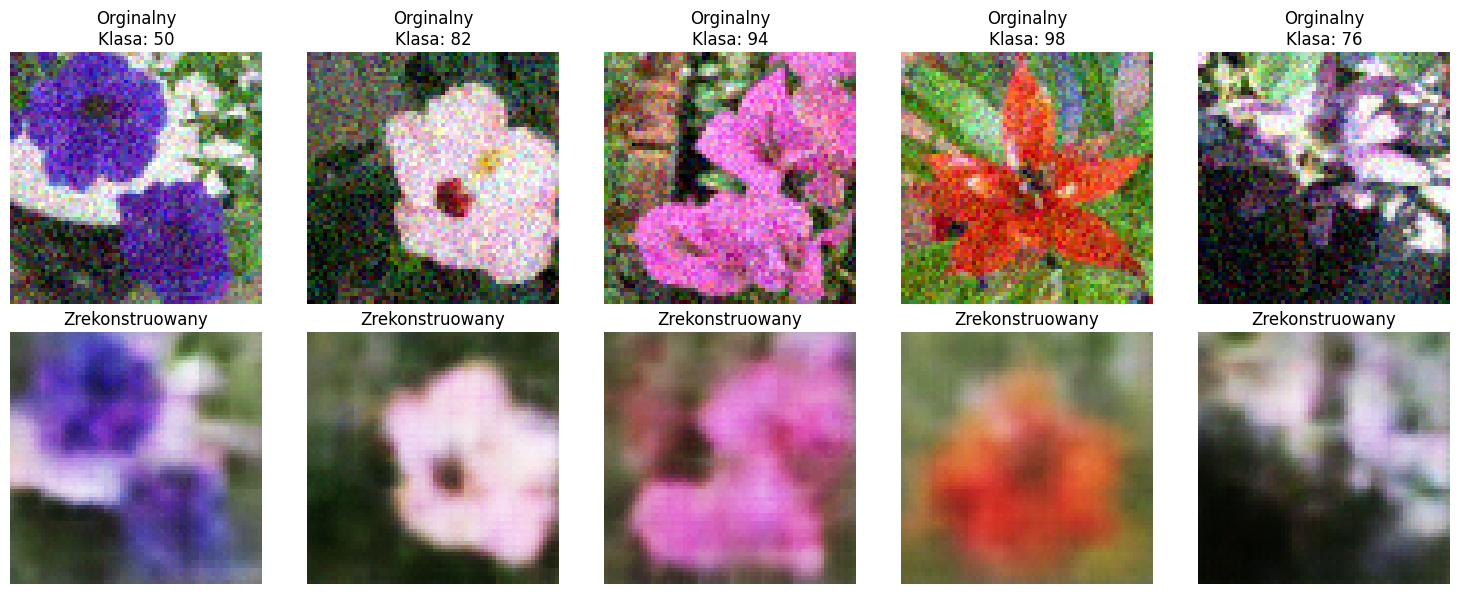

In [ ]:
import random

num_samples = 5
indices = random.sample(range(imgs.shape[0]), num_samples)

plt.figure(figsize=(num_samples * 3, 6))
for i, idx in enumerate(indices):
    # Original
    plt.subplot(2, num_samples, i + 1)
    noise = torch.randn_like(imgs[idx]) * 0.1  # szum gaussowski
    imgs[idx] = torch.clamp(imgs[idx] + noise, 0., 1.)
    plt.imshow(imgs[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Orginalny\nKlasa: {labels[idx].item()}")
    plt.axis("off")
    # Reconstructed
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(recon[idx].permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Zrekonstruowany")
    plt.axis("off")
plt.tight_layout()
plt.show()